# Stint
## Data test Gus Hinestrosa
I initially thought that some sort of predictive model could fit the required solution. However, on a econd read I realised that this is more about building some sort of recommender (or a model that could be used as a recommender or as a way to understand similarities between the stints).<br>
A way to relate roles to selection criteria is to consider each row of the dataset as an item with its own characteristics. If we manage to abstract these characteristics into a collection of vectors, then the problem becomes straight forward: get the desired selection criteria and check the stint or group of stints that are most similar. This also allows us to get a representation of all the stints that can be then selected acording to one or more or the criteria (on a plot, for example) and then help choose the right set of criteria<br> 
There is an important consideration in the exercise description: the importance of each criteria in the definition of each role. <br> A way to approach this would be to build a machine learning model that predicts the type of role (or probably a combination of role+second criterium) based on the rest of the selection criteria. No, we do not look for performance and indeed pretending to predcit roles from selection criteria can be a "non-problem". However, what we do want is to understand how the different criteria affect the stint space the most. Which criteria are core to the definition of a stint? 


Given the above, what I suggest is:
- load and explore the data,
- some plts to explore some major trends,
- clean, edit the datasets and engineer certain features - depending on the models that will be built,
- project each stint into an embedding; possibly built using a encoder-decoder architecture (first guess... might or might not work!),
- build a second model where we most of the criteria are used to predit the highest-level variables (Role, for example). This will give us a good sense of the importance of each criteria in the system. 
- some plots (if time allows, otherwise I'll show the concept in the presentation)

In [1]:
import os
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## reading the data

In [2]:
stints_data = pd.read_csv('/Users/Tavo/code/stint/students-jobs/packages/mlmodel/mlmodel/datasets/test_interview_18022020.csv', index_col=0)

## basic exploration of the dataset

In [3]:
stints_data.columns

Index(['Role ', 'Part of chain?', 'Repeats?',
       'Include Repeats From Other Business', 'Student Level ',
       'Stint Count Min ', 'Stint Count Max', 'Screening Badge?',
       'Screening Grade Min ', 'Average Rating Minimum ',
       'Include new students?', 'Runner Count ', 'Bar Back Count ',
       'KP Count ', 'Waiter / Waitress Count ', 'Runner 4/5* Count ',
       'Bar Back 4/5* Count', 'KP 4/5* Count', 'Waiter / Waitress 4/5* Count',
       'Business'],
      dtype='object')

basic input analysis: <br>
- shape
- null values
- variable types
- etc

In [4]:
stints_data.head()

,Role,Part of chain?,Repeats?,Include Repeats From Other Business,Student Level,Stint Count Min,Stint Count Max,Screening Badge?,Screening Grade Min,Average Rating Minimum,Include new students?,Runner Count,Bar Back Count,KP Count,Waiter / Waitress Count,Runner 4/5* Count,Bar Back 4/5* Count,KP 4/5* Count,Waiter / Waitress 4/5* Count,Business
0,KP,No,Once in a while,NaN,All Levels,1,20.0,NaN,3.00,4.0,Yes if busy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Bar Back,No,Most of the time,NaN,All Levels,2,NaN,NaN,3.00,4.5,No,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1
2,Host/Hostess,No,Most of the time,NaN,All Levels,2,NaN,[Reiss],4.25,4.5,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,KP,No,Most of the time,NaN,All Levels,2,NaN,NaN,3.00,4.5,No,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2
4,Runner,No,Most of the time,NaN,All Levels,2,NaN,NaN,3.00,4.5,No,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,2


In [5]:
stints_data.shape

(445, 20)

simplify the column names

In [6]:
cols_ = [s.replace(' ', '_') for s in stints_data.columns]
cols_ = [s.replace('?', '') for s in cols_]
cols_ = [s.replace('*', '_') for s in cols_]
cols_ = [s.replace('/', '') for s in cols_]


stints_data.columns = cols_

some fields have substantial number of null values

In [7]:
stints_data.isna().sum()

Role_                                    0
Part_of_chain                            0
Repeats                                  0
Include_Repeats_From_Other_Business    356
Student_Level_                           0
Stint_Count_Min_                         0
Stint_Count_Max                        297
Screening_Badge                        363
Screening_Grade_Min_                     0
Average_Rating_Minimum_                  0
Include_new_students                     0
Runner_Count_                          423
Bar_Back_Count_                        442
KP_Count_                              425
Waiter__Waitress_Count_                423
Runner_45_Count_                       313
Bar_Back_45_Count                      371
KP_45_Count                            362
Waiter__Waitress_45_Count              314
Business                                 0
dtype: int64

the datatypes seem about right

In [7]:
stints_data.dtypes

Role_                                   object
Part_of_chain                           object
Repeats                                 object
Include_Repeats_From_Other_Business     object
Student_Level_                          object
Stint_Count_Min_                         int64
Stint_Count_Max                        float64
Screening_Badge                         object
Screening_Grade_Min_                   float64
Average_Rating_Minimum_                float64
Include_new_students                    object
Runner_Count_                          float64
Bar_Back_Count_                        float64
KP_Count_                              float64
Waiter__Waitress_Count_                float64
Runner_45_Count_                       float64
Bar_Back_45_Count                      float64
KP_45_Count                            float64
Waiter__Waitress_45_Count              float64
Business                                 int64
dtype: object

In [8]:
stints_data.Repeats.unique()

array(['Once in a while', 'Most of the time', 'Never', 'Always',
       'Try repeats first', 'Only repeats'], dtype=object)

In [80]:
categorical = [
                'Role_', 
                'Part_of_chain', 
                'Repeats',
                'Include_Repeats_From_Other_Business', 
                'Student_Level_',
                'Screening_Badge',
                'Include_new_students', 
                'Business'
]


In [ ]:
numerical = ["Stint_Count_Min_", 
            'Stint_Count_Max', 
            'Screening_Grade_Min_', 
            'Average_Rating_Minimum_',
            'Runner_Count_', 
            'Bar_Back_Count_',
            'KP_Count_', 
            'Waiter__Waitress_Count_', 
            'Runner_45_Count_',
            'Bar_Back_45_Count',
            'KP_45_Count', 
            "Waiter__Waitress_45_Count"]



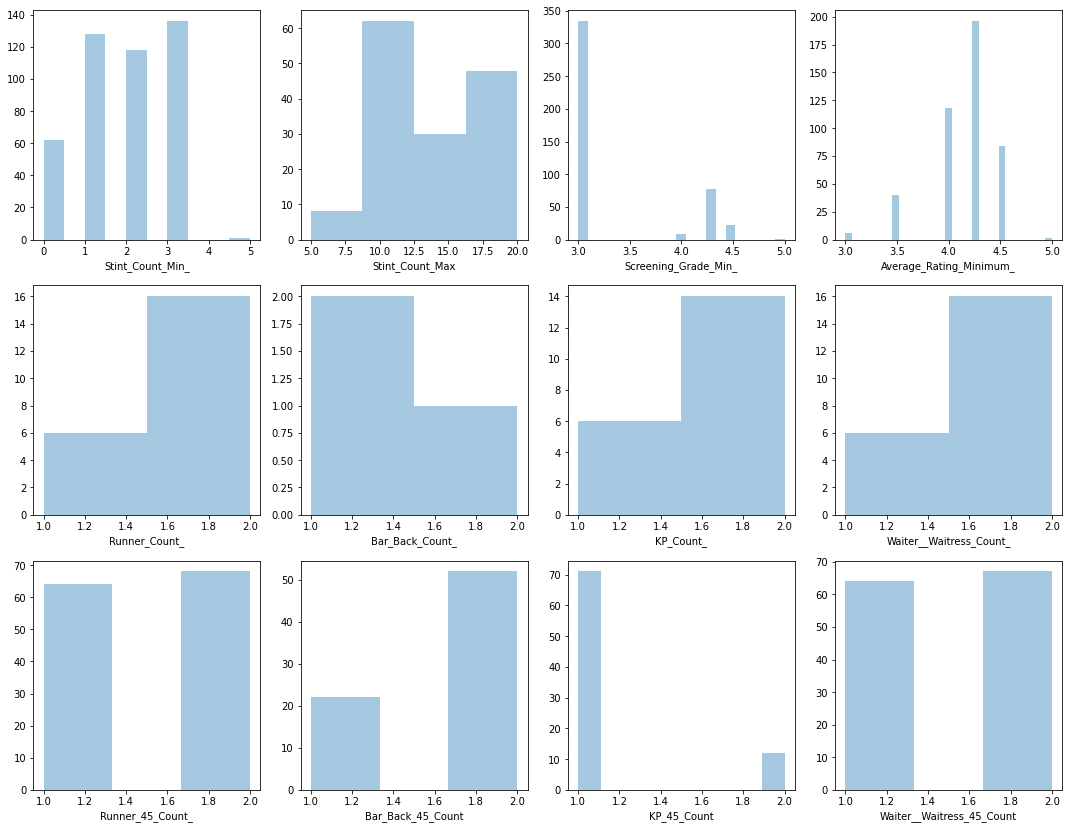

In [34]:
plt.figure(figsize=(15,15))

n = 1
for col in stints_data[numerical]:
    plt.subplot(4,4,n)
    sns.distplot(stints_data[col], kde=False)
    n += 1
plt.tight_layout()

let's identify from now the possible categorical and numerical variables - handy later!

In reality we could consider most of the numerical variables as categorical. Most of them have three values: Null, value1, value2 - NOT a continuous distribution that could be parametrised.

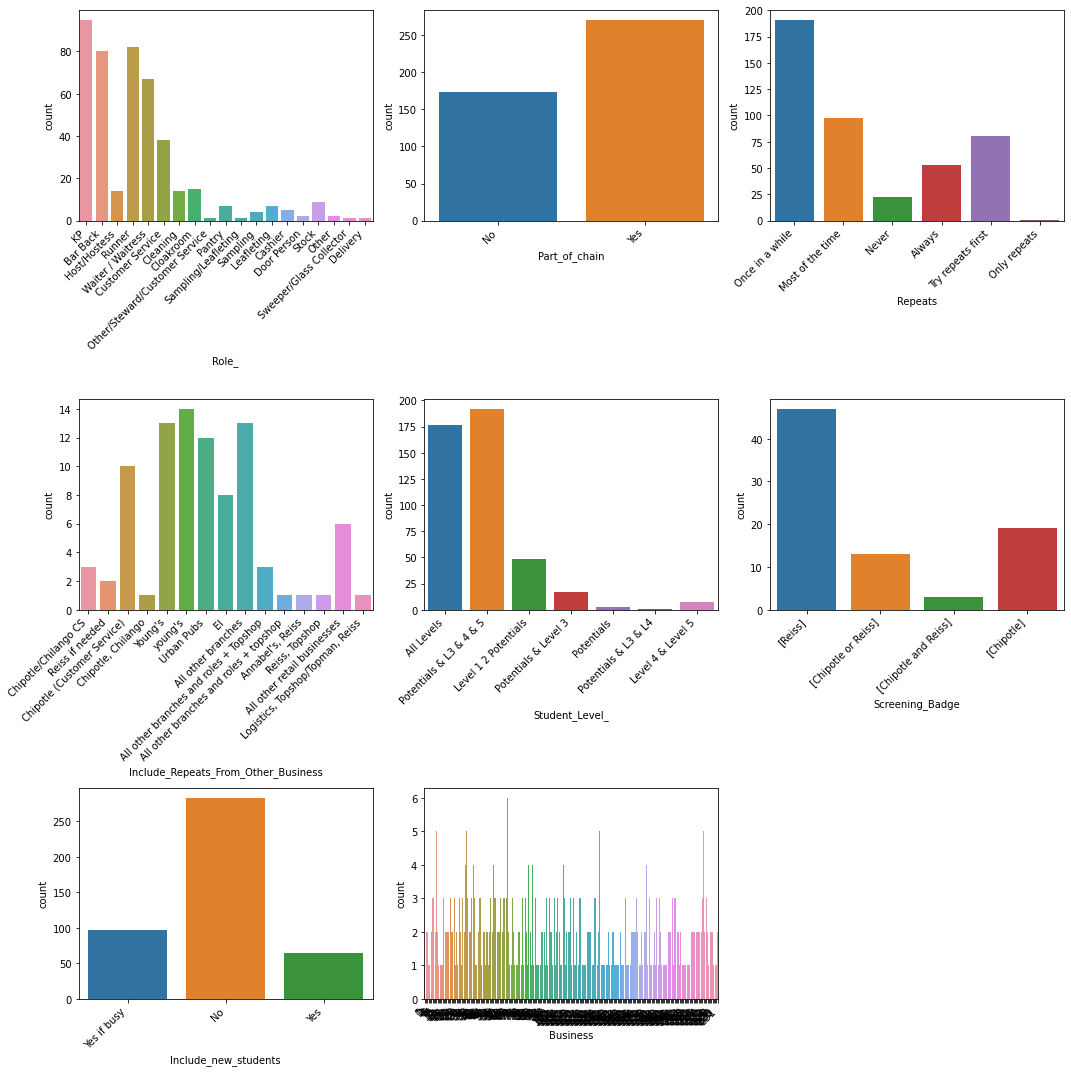

In [40]:
plt.figure(figsize=(15,15))

n = 1
for col in stints_data[categorical]:
    plt.subplot(3,3,n)
    chart = sns.countplot(stints_data[col])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    n += 1
plt.tight_layout()

## dataset issues, observations and trends

The data above deserves some exploration (next section is just a sample), but given the limited time, I dedicated more effort on building the models.<br>
Some observations:
- Some features could be simplified:<br>
-- Repeats: "always" and "only repeats" could be joined (same???)<br>
-- Student level: we can join those labels with similar characteristics but low frequency ("potentials", Potentials & L3 & L4)


## processing
...and let's define functions as much as possible which can then become part of a pipeline, and then we ease deployment...!

In [181]:
stints_data.columns

Index(['Role_', 'Part_of_chain', 'Repeats',
       'Include_Repeats_From_Other_Business', 'Student_Level_',
       'Stint_Count_Min_', 'Stint_Count_Max', 'Screening_Badge',
       'Screening_Grade_Min_', 'Average_Rating_Minimum_',
       'Include_new_students', 'Runner_Count_', 'Bar_Back_Count_', 'KP_Count_',
       'Waiter__Waitress_Count_', 'Runner_45_Count_', 'Bar_Back_45_Count',
       'KP_45_Count', 'Waiter__Waitress_45_Count', 'Business'],
      dtype='object')

In [81]:
# a copy to play with, this is the input training dataset
X = stints_data.copy()



### step 1: drop chosen columns

In [ ]:
# huge cardinality, let's not use business - potentially we could group it in 'business group' or sectors
X = X.drop(['Business'], axis=1)

In [82]:
# let's take business out of the categorical list
categorical.remove('Business')

# and let's add those that we want to treat as categorical
categorical #+ ['Runner_Count_', 'Bar_Back_Count_', 'KP_Count_', 'Waiter__Waitress_Count_', 'Runner_45_Count_', 'Bar_Back_45_Count', 'KP_45_Count', 'Waiter__Waitress_45_Count']

['Role_',
 'Part_of_chain',
 'Repeats',
 'Include_Repeats_From_Other_Business',
 'Student_Level_',
 'Screening_Badge',
 'Include_new_students']

In [83]:
X.isna().sum()

Role_                                    0
Part_of_chain                            0
Repeats                                  0
Include_Repeats_From_Other_Business    356
Student_Level_                           0
Stint_Count_Min_                         0
Stint_Count_Max                        297
Screening_Badge                        363
Screening_Grade_Min_                     0
Average_Rating_Minimum_                  0
Include_new_students                     0
Runner_Count_                          423
Bar_Back_Count_                        442
KP_Count_                              425
Waiter__Waitress_Count_                423
Runner_45_Count_                       313
Bar_Back_45_Count                      371
KP_45_Count                            362
Waiter__Waitress_45_Count              314
dtype: int64

### step 2: treat continuous variables

In [84]:
# let's fill  the null values of the numerical values
# treating differently the 'defaults' for the max and for the min scores

# def treat_continuous():

# for the max 
max_stints_default = X.Stint_Count_Max.max() # default parameter could be made more sophisticated, but that's it for now
X['Stint_Count_Max'] = X['Stint_Count_Max'].fillna(max_stints_default)
# for the others 
for col in numerical:
    X[col] = X[col].fillna(0)




### step 3: treat categorical variables (and those incremental variables with low cardinality)

In [85]:
# let's define as categorical - so we can access some handy panda modules
# option for later: rare labels imputer/fixer

# def treat_categorical(categorical_cols, additional_cols):
for col in categorical:
    X[col] = X[col].fillna("missing")

columns = categorical + ['Runner_Count_', 'Bar_Back_Count_', 'KP_Count_', 'Waiter__Waitress_Count_', 'Runner_45_Count_', 'Bar_Back_45_Count', 'KP_45_Count', 'Waiter__Waitress_45_Count']
X = pd.get_dummies(X, columns=columns)

#obj_df["body_style"] = obj_df["body_style"].astype('category')
#obj_df["body_style_cat"] = obj_df["body_style"].cat.codes
#pd.get_dummies(obj_df, columns=["body_style", "drive_wheels"], prefix=["body", "drive"]).head()


['KP' 'Bar Back' 'Host/Hostess' 'Runner' 'Waiter / Waitress'
 'Customer Service' 'Cleaning' 'Cloakroom'
 'Other/Steward/Customer Service' 'Pantry' 'Sampling/Leafleting'
 'Sampling' 'Leafleting' 'Cashier' 'Door Person' 'Stock' 'Other'
 'Sweeper/Glass Collector' 'Delivery']
['No' 'Yes']
['Once in a while' 'Most of the time' 'Never' 'Always' 'Try repeats first'
 'Only repeats']
['missing' 'Chipotle/Chilango CS' 'Reiss if needed'
 'Chipotle (Customer Service)' 'Chipotle, Chilango' "Young's" "young's"
 'Urban Pubs' 'EI' 'All other branches'
 'All other branches and roles + Topshop'
 'All other branches and roles + topshop' "Annabel's, Reiss"
 'Reiss, Topshop' 'All other retail businesses'
 'Logistics, Topshop/Topman, Reiss']
['All Levels' 'Potentials & L3 & 4 & 5' 'Level 1 2 Potentials'
 'Potentials & Level 3' 'Potentials' 'Potentials & L3 & L4'
 'Level 4 & Level 5']
['missing' '[Reiss]' '[Chipotle or Reiss]' '[Chipotle and Reiss]'
 '[Chipotle]']
['Yes if busy' 'No' 'Yes']


In [86]:
X.head()

,Stint_Count_Min_,Stint_Count_Max,Screening_Grade_Min_,Average_Rating_Minimum_,Role__Bar Back,Role__Cashier,Role__Cleaning,Role__Cloakroom,Role__Customer Service,Role__Delivery,...,Runner_45_Count__2.0,Bar_Back_45_Count_0.0,Bar_Back_45_Count_1.0,Bar_Back_45_Count_2.0,KP_45_Count_0.0,KP_45_Count_1.0,KP_45_Count_2.0,Waiter__Waitress_45_Count_0.0,Waiter__Waitress_45_Count_1.0,Waiter__Waitress_45_Count_2.0
0,1,20.0,3.00,4.0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,2,20.0,3.00,4.5,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
2,2,20.0,4.25,4.5,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
3,2,20.0,3.00,4.5,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
4,2,20.0,3.00,4.5,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,1


### step 4: scale between -1 and 1

In [190]:
X = X.astype('float32')
scaler = StandardScaler((-1,1))
X_scale = scaler.fit_transform(X)

#### warning: the scalet to be change to be trained ONLY on the training dataset ##### TODO
#x_test = x_test.astype('float32') / 255.
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
#x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
X_scale.shape
#print x_test.shape

(445, 86)

### step 5: create test dateset
We will pretend for a sec that these are those stints that have not happened yet. They are a series of selection criteria that could be very similar (or not) to past stints 

In [191]:
# it will be a small evaluation dataset, only 20 (ca. 5% of the data) as we are just proving the concept

X_test = X.iloc[-20:]
X_train = X.iloc[:-20]


## Encoder-decoder
Being on of the key tools that we will build, let's crack on with this and we will eventually be back to the dataset

### step 1: import the required modules

In [192]:
from keras import backend
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.callbacks import TensorBoard


from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [193]:
len(stints_data.columns)

20

### step 2: define the architecture of the model

In [194]:
# eventually we want to instanciate this to include it inside the pipeline as an Estimator

# this is the size of our encoded representations
encoding_dim = 19  # 19 floats -> arbitrary, because there are roughly 20 criteria represented in 86 variables

# this is our input placeholder
input_img = Input(shape=(86,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(86, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

### step 3: define the encoder model

In [163]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)


In [164]:
# create a placeholder for an encoded (20-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [195]:
### step 4: compile the autoencoder model

In [196]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error') #mean_squared_error binary_crossentropy


 ### step 5: train the autoencoder

In [198]:
backend.clear_session()


In [208]:
autoencoder.fit(X_train, X_train,
                epochs=1000,
                batch_size=50,
                shuffle=True,
                callbacks=[TensorBoard(log_dir='/Users/tavo/code/stint/tmp/autoencoder')]
)

===========] - 0s 1ms/step - loss: 3.8149
Epoch 756/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.8149
Epoch 757/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.8149
Epoch 758/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.8149
Epoch 759/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.8149
Epoch 760/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.8149
Epoch 761/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.8149
Epoch 762/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.8149
Epoch 763/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.8149
Epoch 764/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.8149
Epoch 765/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.8149
Epoch 766/1000
9/9 [==============================] - 0s 1ms/step - loss: 3.8149
Epoch 767/1000
9/9 [==============================] - 0s 1ms/step -

In [300]:
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)
encoded_all = encoder.predict(X)

In [217]:
# this is the results: each stint encoded in a set of 20 floats
encoded_train[:2]

array([[1.844766  , 0.        , 6.4377036 , 3.7083488 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 5.3379006 ,
        0.        , 0.        , 1.9994825 , 0.        , 0.03951304,
        0.        , 5.919968  , 2.137493  , 0.        ],
       [1.4863799 , 0.        , 7.02097   , 3.5837102 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 5.132631  ,
        0.        , 0.03636045, 1.4114146 , 0.        , 0.16036123,
        0.        , 6.240148  , 2.789438  , 0.        ]], dtype=float32)

In [219]:
stints_data.iloc[0], encoded_train[0]

(Role_                                               KP
 Part_of_chain                                       No
 Repeats                                Once in a while
 Include_Repeats_From_Other_Business                NaN
 Student_Level_                              All Levels
 Stint_Count_Min_                                     1
 Stint_Count_Max                                     20
 Screening_Badge                                    NaN
 Screening_Grade_Min_                                 3
 Average_Rating_Minimum_                              4
 Include_new_students                       Yes if busy
 Runner_Count_                                      NaN
 Bar_Back_Count_                                    NaN
 KP_Count_                                          NaN
 Waiter__Waitress_Count_                            NaN
 Runner_45_Count_                                   NaN
 Bar_Back_45_Count                                  NaN
 KP_45_Count                                    

### calculating distances

In [177]:
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

A = encoded_train

dist_out = 1-pairwise_distances(A, metric="cosine")
dist_out

array([[1.        , 0.36523688, 0.53973496, ..., 0.5206123 , 0.5206123 ,
        0.28800702],
       [0.36523688, 1.        , 0.62585473, ..., 0.30113983, 0.30113983,
        0.3080271 ],
       [0.53973496, 0.62585473, 1.        , ..., 0.5307868 , 0.5307868 ,
        0.30847114],
       ...,
       [0.5206123 , 0.30113983, 0.5307868 , ..., 1.        , 1.        ,
        0.22795463],
       [0.5206123 , 0.30113983, 0.5307868 , ..., 1.        , 1.        ,
        0.22795463],
       [0.28800702, 0.3080271 , 0.30847114, ..., 0.22795463, 0.22795463,
        1.        ]], dtype=float32)

### suggesting the top n most similar stints

In [ ]:
# when we get a new set of stints, we just need to:
# - add the to the matrix
# - recalculate distances
# map back to the original data to get the characteristics in human readable form

# 

### visualisation

In [229]:
from IPython.core.interactiveshell import InteractiveShell
from sklearn.manifold import TSNE
import umap

In [226]:
def reduce_dim(weights, components=3, method='tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric='cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [301]:
stints_r = reduce_dim(encoded_train, components=2, method='tsne')
stints_r.shape

stints_new = reduce_dim(encoded_test, components=2, method='tsne')
stints_new.shape

stints_all = reduce_dim(encoded_all, components=2, method='tsne')


In [323]:
roles_train = stints_data.iloc[:-20].Role_
roles_test = stints_data.iloc[-20:].Role_
roles_all = stints_data.Role_

In [324]:
ints, roles_tr = pd.factorize(roles_train.to_list())
roles_dict = {r: n for n,r in enumerate(roles_tr)}
ints_te = [roles_dict[r] for r in roles_test]
ints_all = [roles_dict[r] for r in roles_all]

Text(0.5, 1.0, 'Embeddings Visualized with TSNE')

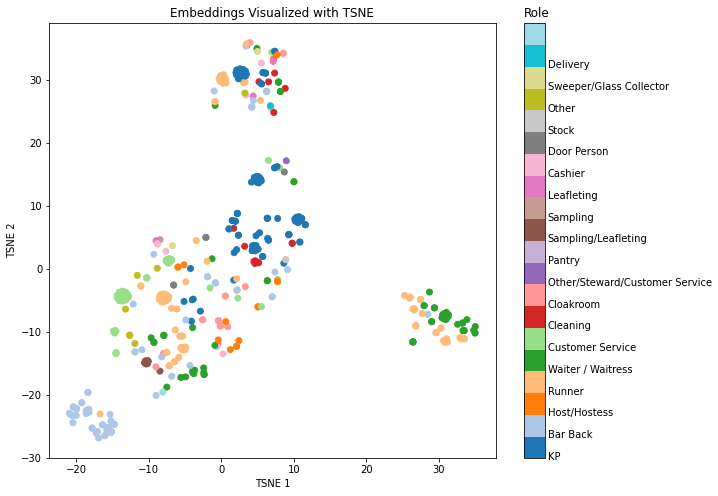

In [267]:
from matplotlib import colors

InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))

#cmap = plt.cm.rainbow
#norm = colors.Normalize(vmin=1.5, vmax=4.5)

# plot
plt.scatter(stints_r[:, 0], stints_r[:, 1], c=ints, cmap=plt.cm.tab20) #color=cmap(norm(ints)))


# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(roles_tr):
    cbar.ax.text(20, (18 * j + 1) / ((10) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Role', loc='left')

plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.title('Embeddings Visualized with TSNE')


### and now we want to plot the new stints from the validation dataset X_test

Text(0.5, 1.0, 'Embeddings Visualized with TSNE')

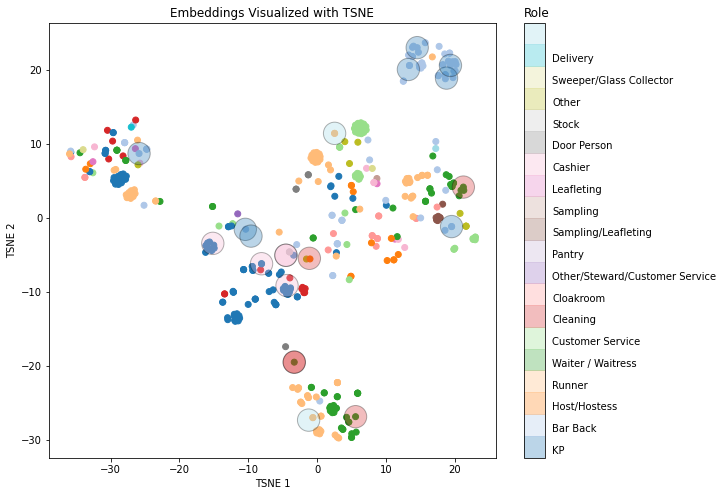

In [343]:
from matplotlib import colors

InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))

#cmap = plt.cm.rainbow
#norm = colors.Normalize(vmin=1.5, vmax=4.5)

# plot
plt.scatter(stints_all[:-20, 0], stints_all[:-20, 1], c=ints, cmap=plt.cm.tab20) #color=cmap(norm(ints)))
plt.scatter(stints_all[-20:, 0], stints_all[-20:, 1], s=500, edgecolor='k', cmap=plt.cm.tab20, c=ints_test, alpha=0.3)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(roles_tr):
    cbar.ax.text(4, (3 * j + 1) / ((10) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Role', loc='left')

plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.title('Embeddings Visualized with TSNE')